In [5]:
from tqdm import tqdm
from torchvision import transforms
from utils.params import Params
import models.rcan
import models.ninab1
import models.ninab2_20m
import models.edsr
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

In [11]:
### CONFIG ###
channels = [4, 5, 6, 7, 8, 9]
model_files = ["ninab2_20m_v0"]
path = "../Dataset/Unscaled/2807-06-037-1103"

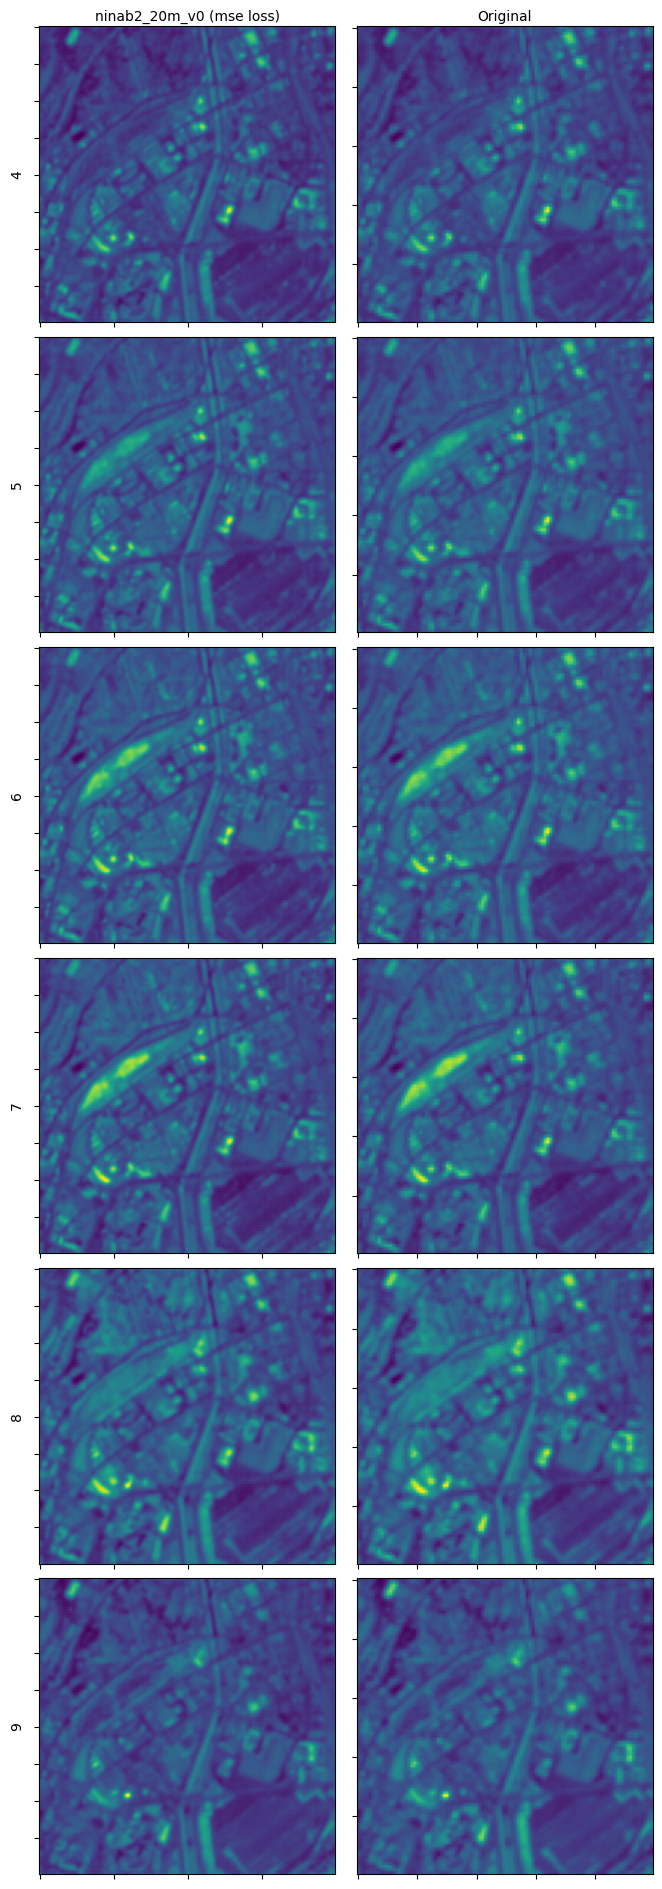

<Figure size 800x2400 with 0 Axes>

In [12]:
#Setup
model_dict = {
    "edsr": models.edsr,
    "rcan": models.rcan,
    "ninab1": models.ninab1,
    "ninab2": models.ninab2_20m
}
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
trans = transforms.Compose([
    transforms.ToTensor()])

#Load in and prepare the trained models
trained_models = [] #array of model objects
losses = []
for model_file in model_files:
    params = Params("saved_models/" + model_file + "_hparams.yaml", "DEFAULT")
    losses.append(params.loss_fn)
    model_type = model_file[:model_file.find("_")]
    model_shell = model_dict[model_type]
    trained_model = model_shell.net(params).to(device)
    trained_model.load_state_dict(torch.load("saved_models/" + model_file + ".ckpt"))
    trained_models.append(trained_model)

#Configure the subplots
plt.rcParams['figure.figsize'] = [4 * (len(trained_models) + 1), 4 * len(channels)]
fig, ax = plt.subplots(len(channels), len(trained_models)+1) #sharex=True, sharey=True)
plt.figure(dpi=100)
fig.subplots_adjust(hspace=0.05, wspace=0.05)
#fig.tight_layout()

#Now plot everything
for channel_index, channel in enumerate(channels):
    #Prepare input image
    im = cv2.imread(path + "_" + str(channel) + ".png")
    im = im / 255.0
    hr = im[:, :, 0] #images are saved as 3 channel pngs, but the channels are identical and we only want 1
    input_hr = trans(hr).float()

    #Plot the SRs and the HR image
    for model_index, model in enumerate(trained_models):
        sr = model(input_hr).detach().numpy().reshape((3, 200, 200))[0, :, :]
        ax[channel_index][model_index].imshow(sr)

        #Set the model labels
        if channel_index == 0:
            ax[0][model_index].set_xlabel(model_files[model_index] + " (" + losses[model_index] + " loss)")
            ax[0][model_index].xaxis.set_label_position('top')

        #Clear tick labels for all plots
        ax[channel_index][model_index].set_xticklabels([])
        ax[channel_index][model_index].set_yticklabels([])

    #Plot the original
    ax[channel_index][len(trained_models)].imshow(hr)
    ax[channel_index][len(trained_models)].set_xticklabels([])
    ax[channel_index][len(trained_models)].set_yticklabels([])
    
    #Channel titles
    ax[channel_index][0].set_ylabel(channel)

ax[0][len(trained_models)].set_xlabel("Original")
ax[0][len(trained_models)].xaxis.set_label_position('top')

plt.show()
